# Data Basic Situation Check

In [1]:
# Basic Settings and Data Reading

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

# Read Dataset
df = pd.read_csv("HR_comma_sep.csv")

df.head()

C:\Users\TSY\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [2]:
# Basic data information

print("Shape of data:", df.shape)
print("\nData types:")
print(df.dtypes)

print("\nMissing values:")
print(df.isna().sum())

print("\nNumber of duplicated rows:", df.duplicated().sum())

print("\nDescriptive statistics for numerical features:")
print(df.describe().T)

Shape of data: (14999, 10)

Data types:
satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
Department                object
salary                    object
dtype: object

Missing values:
satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
Department               0
salary                   0
dtype: int64

Number of duplicated rows: 3008

Descriptive statistics for numerical features:
                         count        mean        std    min     25%     50%  \
satisfaction_level     14999.0    0.612834   0.248631   0.09    0.44    0.64   
last_evaluation        14999.0    0.716102   0.171169   0.36    0.56    0.7

In [3]:
# Target variable distribution & Feature types

print("Target distribution (left):")
print(df["left"].value_counts())
print("\nTarget distribution (proportion):")
print(df["left"].value_counts(normalize=True))

# Field Type
numeric_features = [
    "satisfaction_level",
    "last_evaluation",
    "number_project",
    "average_montly_hours",
    "time_spend_company"
]

binary_features = [
    "Work_accident",
    "promotion_last_5years"
]

categorical_one_hot = ["Department"]   
categorical_ordinal = ["salary"]      
target_col = "left"

Target distribution (left):
left
0    11428
1     3571
Name: count, dtype: int64

Target distribution (proportion):
left
0    0.761917
1    0.238083
Name: proportion, dtype: float64


# EDA

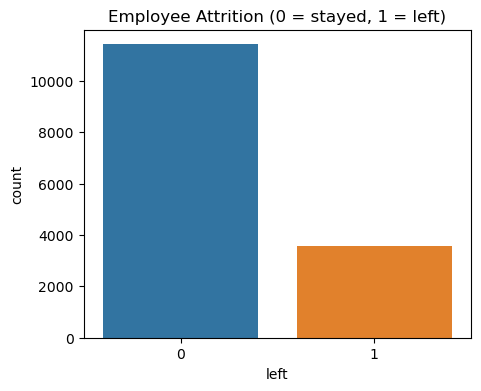

In [4]:
# Target variable count chart

plt.figure(figsize=(5,4))
sns.countplot(x="left", data=df)
plt.title("Employee Attrition (0 = stayed, 1 = left)")
plt.show()

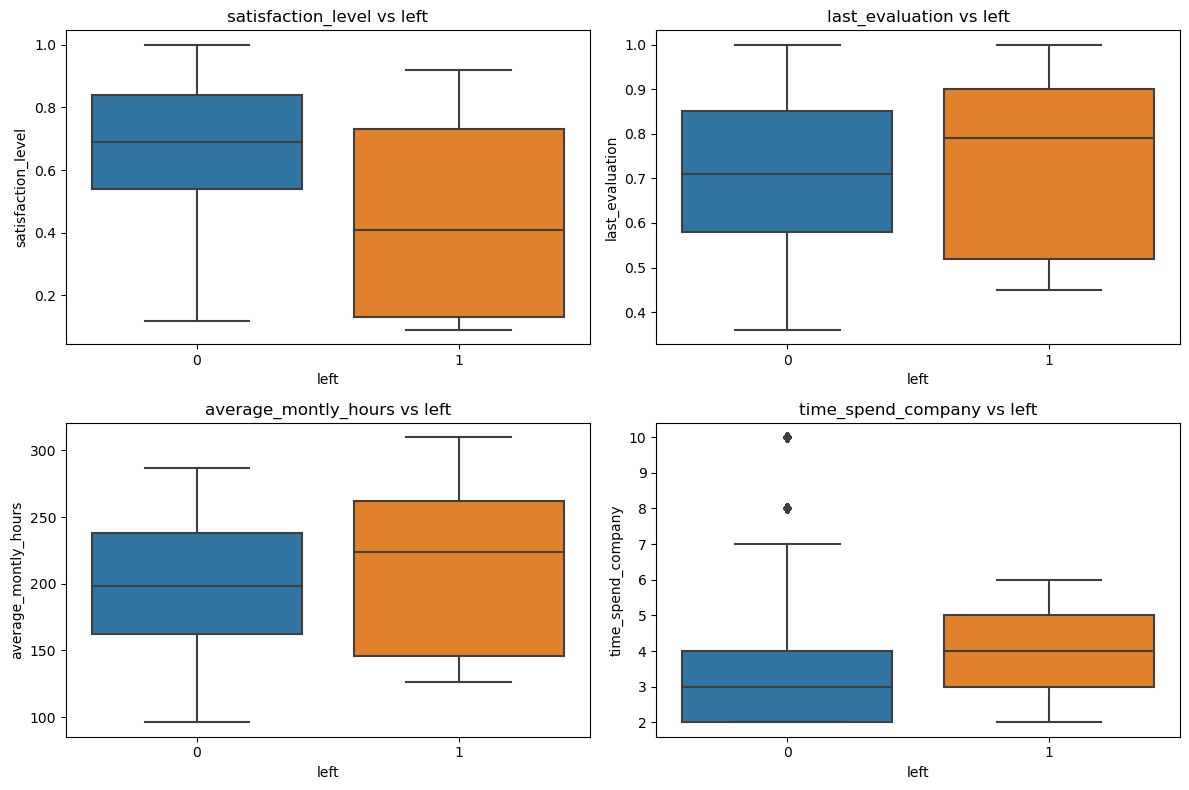

In [5]:
# Box Plot

continuous_for_box = [
    "satisfaction_level",
    "last_evaluation",
    "average_montly_hours",
    "time_spend_company"
]

plt.figure(figsize=(12,8))
for i, col in enumerate(continuous_for_box, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x="left", y=col, data=df)
    plt.title(f"{col} vs left")
plt.tight_layout()
plt.show()

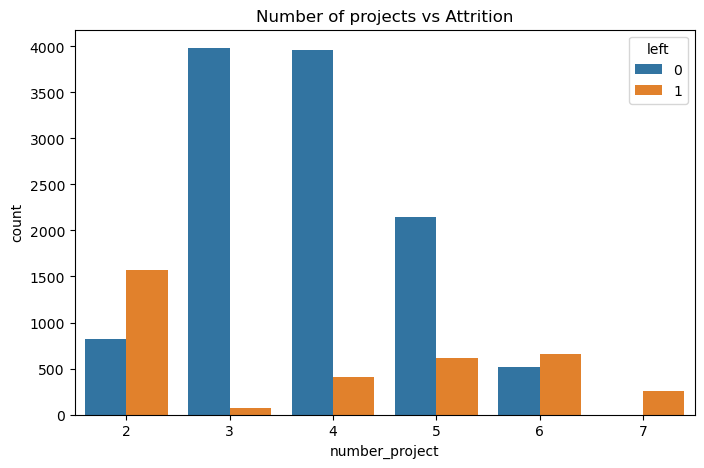

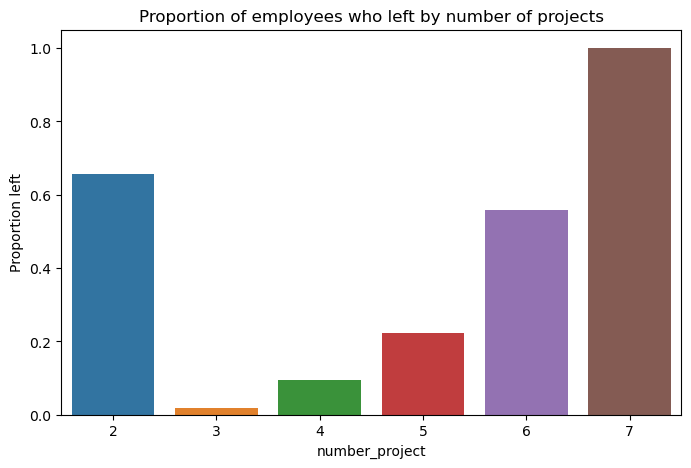

In [6]:
# Bar Chart

plt.figure(figsize=(8,5))
sns.countplot(x="number_project", hue="left", data=df)
plt.title("Number of projects vs Attrition")
plt.show()

# The proportion of "left" within each project number
proj_left_rate = (
    df.groupby("number_project")["left"]
      .mean()
      .reset_index()
      .rename(columns={"left": "left_rate"})
)

plt.figure(figsize=(8,5))
sns.barplot(x="number_project", y="left_rate", data=proj_left_rate)
plt.title("Proportion of employees who left by number of projects")
plt.ylabel("Proportion left")
plt.show()

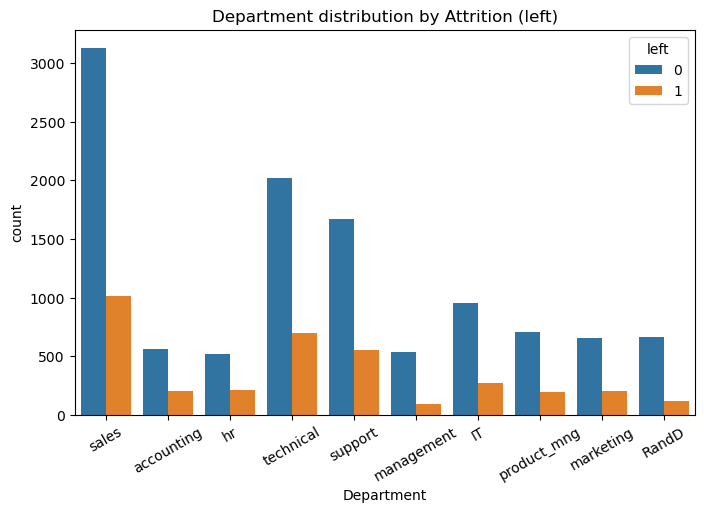

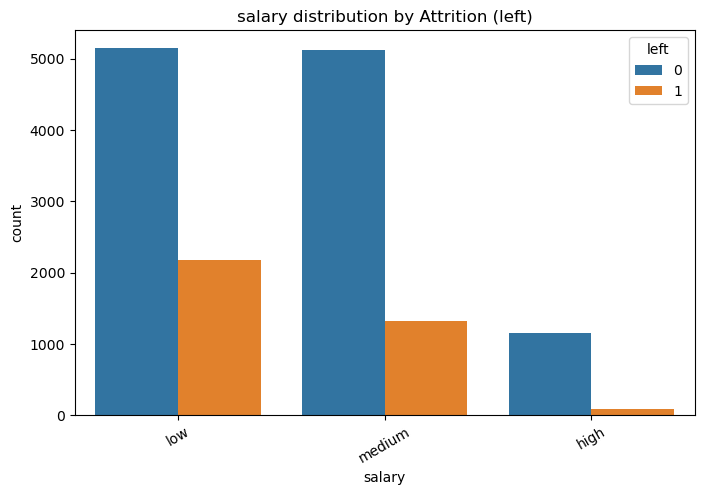

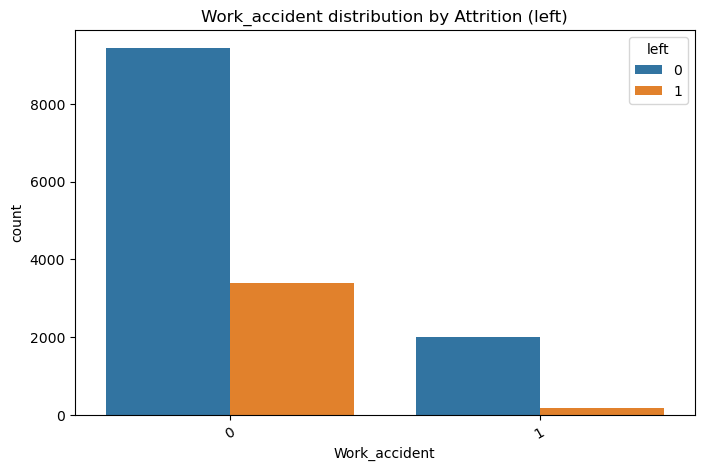

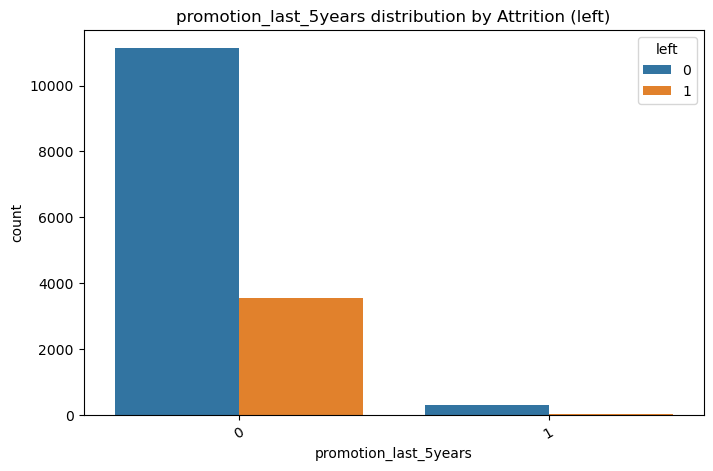

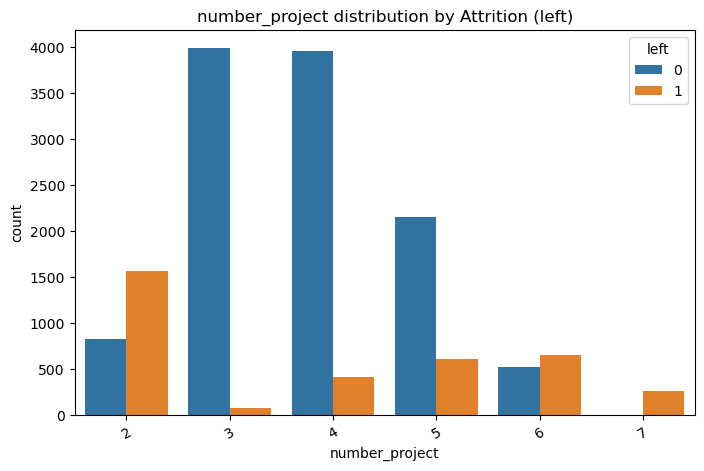

In [7]:
# Countplots for binary features vs left

features_for_countplot = [
    "Department",
    "salary",
    "Work_accident",
    "promotion_last_5years",
    "number_project"
]

for col in features_for_countplot:
    plt.figure(figsize=(8,5))
    sns.countplot(x=col, hue="left", data=df)
    plt.title(f"{col} distribution by Attrition (left)")
    plt.xticks(rotation=30)
    plt.show()

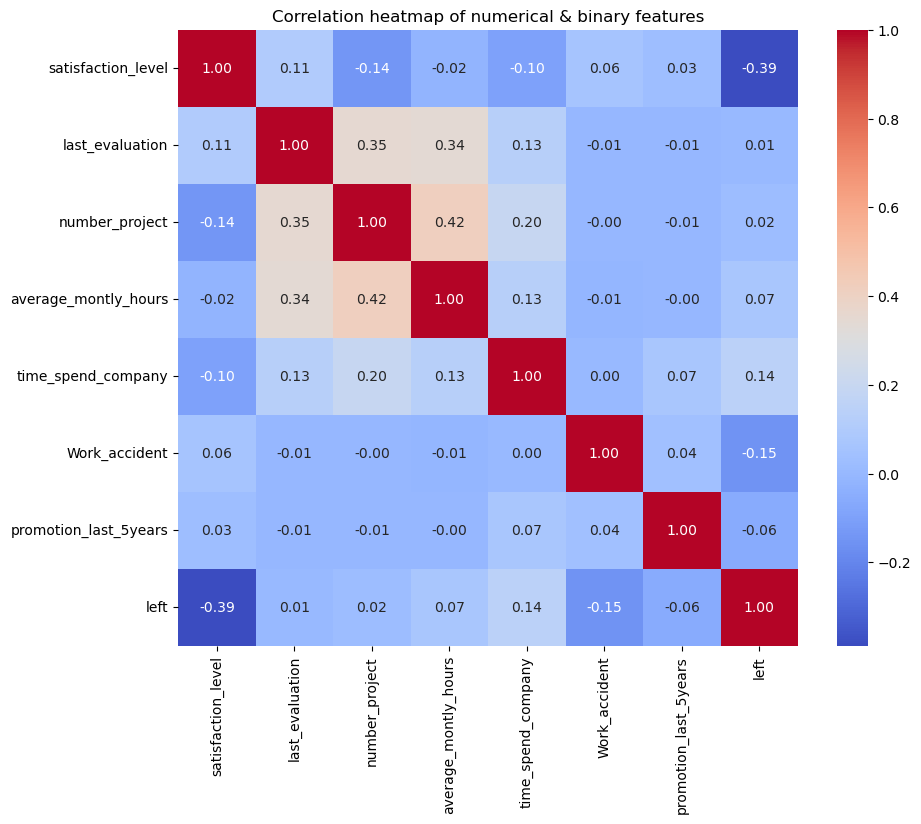

In [8]:
# Correlation heatmap

corr_cols = numeric_features + binary_features + [target_col]
corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation heatmap of numerical & binary features")
plt.show()

# Model Training

In [9]:
# Train / Test split (70% / 30%)

X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,       
    stratify=y,           
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

print("\nTrain target proportion:")
print(y_train.value_counts(normalize=True))
print("\nTest target proportion:")
print(y_test.value_counts(normalize=True))

Train shape: (10499, 9)
Test shape: (4500, 9)

Train target proportion:
left
0    0.761882
1    0.238118
Name: proportion, dtype: float64

Test target proportion:
left
0    0.762
1    0.238
Name: proportion, dtype: float64


In [10]:
# Preprocessing pipeline

# Numerical values + Unified standardization of binary features
numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
)

# OneHot
onehot_transformer = OneHotEncoder(
    drop="first",          
    handle_unknown="ignore"
)

ordinal_transformer = OrdinalEncoder(
    categories=[["low", "medium", "high"]]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features + binary_features),
        ("dept", onehot_transformer, categorical_one_hot),
        ("sal", ordinal_transformer, categorical_ordinal),
    ]
)

In [11]:
# Common GridSearchCV settings
scoring_metric = "roc_auc" 
cv_folds = 5
n_jobs = -1                  

In [12]:
# GridSearch for Logistic Regression

log_reg_clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(
            class_weight="balanced",
            max_iter=1000,
            random_state=42
        ))
    ]
)

log_reg_param_grid = {
    "classifier__C": [0.01, 0.1, 1, 10],
    "classifier__solver": ["lbfgs", "liblinear"]
}

log_reg_grid = GridSearchCV(
    estimator=log_reg_clf,
    param_grid=log_reg_param_grid,
    scoring=scoring_metric,
    cv=cv_folds,
    n_jobs=n_jobs,
    verbose=1
)

log_reg_grid.fit(X_train, y_train)

print("Best params (LogReg):", log_reg_grid.best_params_)
print("Best CV score (LogReg, ROC AUC):", log_reg_grid.best_score_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params (LogReg): {'classifier__C': 0.1, 'classifier__solver': 'lbfgs'}
Best CV score (LogReg, ROC AUC): 0.8264814602876799


In [13]:
# GridSearch for Decision Tree

dt_clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", DecisionTreeClassifier(
            class_weight="balanced",
            random_state=42
        ))
    ]
)

dt_param_grid = {
    "classifier__max_depth": [None, 5, 10, 20],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4]
}

dt_grid = GridSearchCV(
    estimator=dt_clf,
    param_grid=dt_param_grid,
    scoring=scoring_metric,
    cv=cv_folds,
    n_jobs=n_jobs,
    verbose=1
)

dt_grid.fit(X_train, y_train)

print("Best params (Decision Tree):", dt_grid.best_params_)
print("Best CV score (Decision Tree, ROC AUC):", dt_grid.best_score_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params (Decision Tree): {'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10}
Best CV score (Decision Tree, ROC AUC): 0.9816946649468417


In [14]:
# GridSearch for Random Forest

rf_clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(
            class_weight="balanced",
            random_state=42
        ))
    ]
)

rf_param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [None, 5, 10, 20],
    "classifier__min_samples_split": [2, 5],
    "classifier__min_samples_leaf": [1, 2]
}

rf_grid = GridSearchCV(
    estimator=rf_clf,
    param_grid=rf_param_grid,
    scoring=scoring_metric,
    cv=cv_folds,
    n_jobs=n_jobs,
    verbose=1
)

rf_grid.fit(X_train, y_train)

print("Best params (Random Forest):", rf_grid.best_params_)
print("Best CV score (Random Forest, ROC AUC):", rf_grid.best_score_)


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best params (Random Forest): {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best CV score (Random Forest, ROC AUC): 0.992806130003127


In [15]:
# GridSearch for SVM (RBF)

svm_clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", SVC(
            kernel="rbf",
            probability=True,        
            class_weight="balanced",
            random_state=42
        ))
    ]
)

svm_param_grid = {
    "classifier__C": [0.1, 1, 10],
    "classifier__gamma": ["scale", 0.1, 0.01]
}

svm_grid = GridSearchCV(
    estimator=svm_clf,
    param_grid=svm_param_grid,
    scoring=scoring_metric,
    cv=cv_folds,
    n_jobs=n_jobs,
    verbose=1
)

svm_grid.fit(X_train, y_train)

print("Best params (SVM):", svm_grid.best_params_)
print("Best CV score (SVM, ROC AUC):", svm_grid.best_score_)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best params (SVM): {'classifier__C': 10, 'classifier__gamma': 'scale'}
Best CV score (SVM, ROC AUC): 0.9812831618198873


In [16]:
# Collect tuned models

tuned_models = {
    "Logistic Regression": log_reg_grid,
    "Decision Tree": dt_grid,
    "Random Forest": rf_grid,
    "SVM (RBF)": svm_grid
}

In [17]:
# Helper - confusion matrix plot

def plot_confusion_matrix(cm, classes, title="Confusion Matrix"):
    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=classes,
        yticklabels=classes
    )
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.title(title)
    plt.show()

Test performance (tuned) - Logistic Regression
              precision    recall  f1-score   support

           0       0.92      0.76      0.83      3429
           1       0.50      0.79      0.61      1071

    accuracy                           0.76      4500
   macro avg       0.71      0.77      0.72      4500
weighted avg       0.82      0.76      0.78      4500



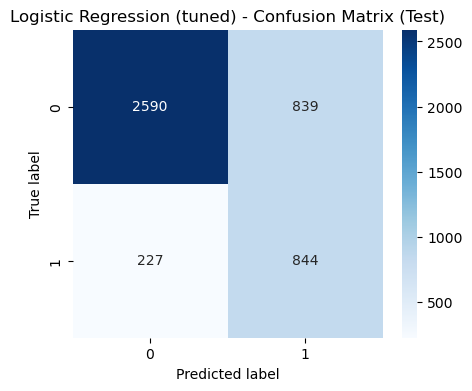

Test performance (tuned) - Decision Tree
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3429
           1       0.90      0.96      0.93      1071

    accuracy                           0.97      4500
   macro avg       0.95      0.97      0.96      4500
weighted avg       0.97      0.97      0.97      4500



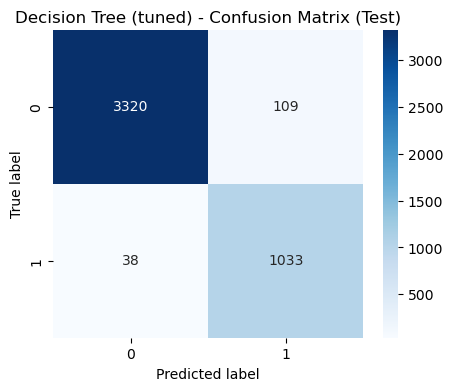

Test performance (tuned) - Random Forest
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3429
           1       0.99      0.95      0.97      1071

    accuracy                           0.99      4500
   macro avg       0.99      0.97      0.98      4500
weighted avg       0.99      0.99      0.99      4500



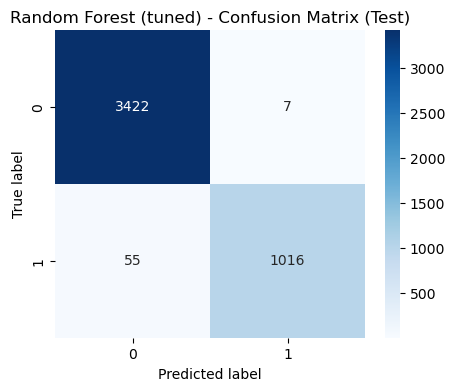

Test performance (tuned) - SVM (RBF)
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      3429
           1       0.91      0.94      0.92      1071

    accuracy                           0.96      4500
   macro avg       0.95      0.95      0.95      4500
weighted avg       0.96      0.96      0.96      4500



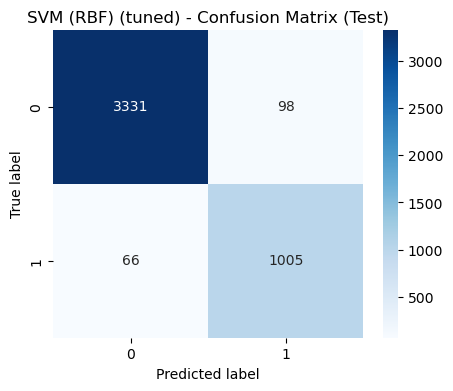

In [18]:
# Evaluate tuned models on test set

fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}
test_predictions = {}

for name, grid in tuned_models.items():
    print("="*60)
    print(f"Test performance (tuned) - {name}")
    
    best_clf = grid.best_estimator_ 
    
    y_test_pred = best_clf.predict(X_test)
    y_test_proba = best_clf.predict_proba(X_test)[:, 1]
    
    test_predictions[name] = {
        "y_pred": y_test_pred,
        "y_proba": y_test_proba
    }
    
    print(classification_report(y_test, y_test_pred))
    
    cm = confusion_matrix(y_test, y_test_pred)
    plot_confusion_matrix(cm, classes=[0, 1],
                          title=f"{name} (tuned) - Confusion Matrix (Test)")
    
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    roc_auc = auc(fpr, tpr)
    
    fpr_dict[name] = fpr
    tpr_dict[name] = tpr
    roc_auc_dict[name] = roc_auc

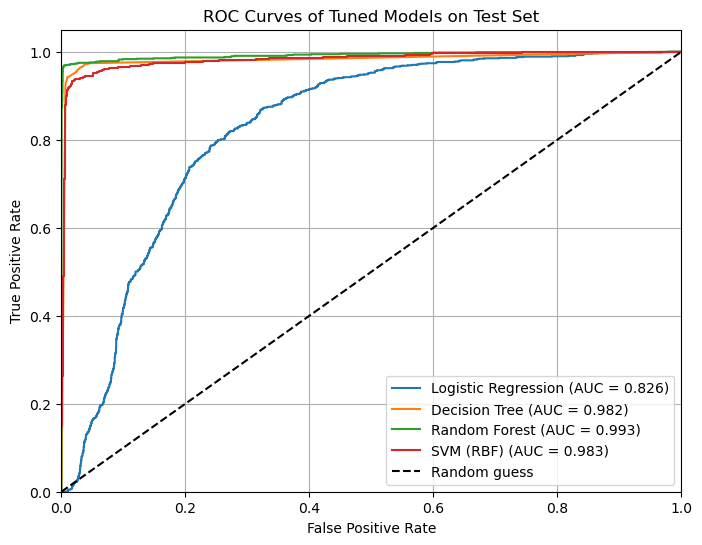

In [19]:
# ROC curves for tuned models on test set

plt.figure(figsize=(8,6))

for name in tuned_models.keys():
    plt.plot(
        fpr_dict[name],
        tpr_dict[name],
        label=f"{name} (AUC = {roc_auc_dict[name]:.3f})"
    )

plt.plot([0, 1], [0, 1], "k--", label="Random guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves of Tuned Models on Test Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

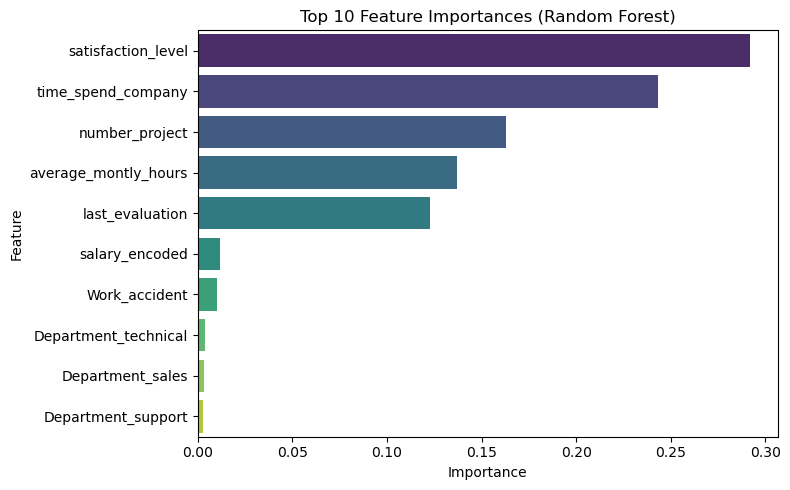

In [21]:
# Feature importance from Random Forest

# Extract the optimal RF pipeline obtained from GridSearch
best_rf_pipeline = rf_grid.best_estimator_

rf_preprocessor = best_rf_pipeline.named_steps["preprocessor"]
rf_model        = best_rf_pipeline.named_steps["classifier"]

# Numerical + Binary features
num_bin_features = numeric_features + binary_features

# Department
dept_ohe = rf_preprocessor.named_transformers_["dept"]
dept_categories = dept_ohe.categories_[0]

# Because we used drop="first", skip the first category
dept_feature_names = [f"{categorical_one_hot[0]}_{cat}" for cat in dept_categories[1:]]

# Salary
salary_feature_names = ["salary_encoded"]

# Combine all feature names in correct order
all_feature_names = num_bin_features + dept_feature_names + salary_feature_names

# Extract feature importance
importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

# Plot Top 10 Features
top_n = 10
top_features = feature_importance_df.head(top_n)

plt.figure(figsize=(8, 5))
sns.barplot(
    x="importance",
    y="feature",
    data=top_features,
    orient="h",
    palette="viridis"
)
plt.title(f"Top {top_n} Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()